In [1]:
import dataloader
import pandas as pd
import utils
from model import generate_model
import os
import torch
import torch.nn as nn
import torch.optim as optim

from train_wrapper import train_epoch

In [2]:
config = utils.load_config()

batch_size = config['dataloader']['batch_size']
num_workers = config['dataloader']['num_workers']
pin_memory = config['dataloader']['pin_memory'] == 1 

In [3]:
#데이터셋 분리(Train, validation, test)
df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna().reset_index(drop=True)
df_oasis = df_dataset[df_dataset['source'] == 'OASIS-3']
df_adni = df_dataset[df_dataset['source'] == 'ADNI']
X_train,X_val,y_train,y_val = dataloader.dataset_split(df_oasis)
X_test = df_adni.drop(labels='group_maxinc',axis=1)
y_test = df_adni['group_maxinc']

d:\MyGit\BrainMR_MCI\dataloader.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['grp'] = (df_dataset['source'].str.replace('OASIS-3','1').str.replace('ADNI','2').apply(pd.to_numeric)*1000


In [4]:
traindata=dataloader.MRIDataset(X_train,y_train)
valdata=dataloader.MRIDataset(X_val,y_val)
testdata=dataloader.MRIDataset(X_test,y_test)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(traindata, batch_size=batch_size, shuffle=True
                              ,num_workers=num_workers,pin_memory = pin_memory)
val_dataloader  = DataLoader(valdata, batch_size=batch_size, shuffle=False
                              ,num_workers=num_workers,pin_memory = pin_memory)
test_dataloader  = DataLoader(testdata, batch_size=1, shuffle=False)

print('train_dataloader : ',len(train_dataloader.dataset))
print('val_dataloader : ',len(val_dataloader.dataset))
print('test_dataloader : ',len(test_dataloader.dataset))

train_dataloader :  659
val_dataloader :  165
test_dataloader :  166


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model, _ = generate_model(model_name='RESNET')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.0001, betas=(0.5, 0.999))
criterion_clf = nn.CrossEntropyLoss().to(device)

cpu


d:\MyGit\BrainMR_MCI\models\resnet.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [6]:
train_epoch(device,train_dataloader,val_dataloader,model,criterion_clf,optimizer,config,epoch=100)

train at epoch 0
Epoch: [0][0/330]	 lr: 0.00010	Time 31.799 (31.799)	Data 19.679 (19.679)	Loss 1.1963 (1.1963)	acc 0.50000 (0.50000)	
Epoch: [0][10/330]	 lr: 0.00010	Time 7.918 (9.685)	Data 0.003 (1.791)	Loss 1.4738 (1.4278)	acc 0.50000 (0.40909)	
Epoch: [0][20/330]	 lr: 0.00010	Time 7.010 (9.001)	Data 0.003 (0.940)	Loss 0.9937 (1.3322)	acc 0.50000 (0.42857)	
Epoch: [0][30/330]	 lr: 0.00010	Time 6.550 (8.405)	Data 0.006 (0.638)	Loss 2.2897 (1.2040)	acc 0.00000 (0.51613)	


KeyboardInterrupt: 

Feature batch shape: torch.Size([2, 1, 128, 128, 128])
Label: 0


IndexError: index 130 is out of bounds for dimension 2 with size 128

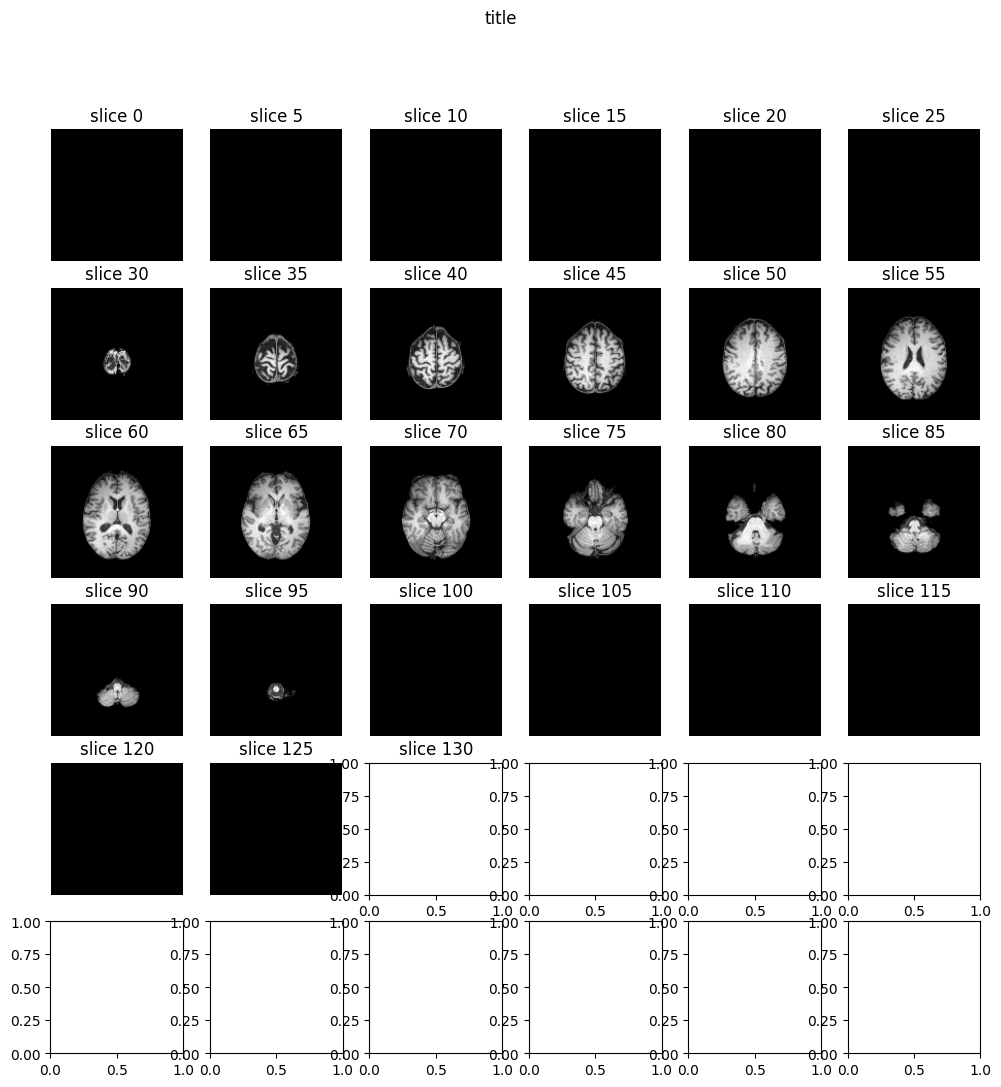

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze() 
label = train_labels[0]
print(f"Label: {label}")
utils.stack_plot(img)